<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Multi_Modal_Predictions/SimpleConcatenation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple Concatenation**
Features from image and metadata are extracted using short MLP and DenseNet121 model, are concatenated to give a final prediction.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121
from PIL import Image
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# **Define Dataset, Classes, and Weights**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_folders.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_test.csv')
images = '/content/drive/MyDrive/Final Year Project/Data/PAD/imgs'

label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['diagnostic'])
test_df['label'] = label_encoder.transform(test_df['diagnostic'])

label_counts = train_df['label'].value_counts().sort_index()

class_weights = 1.0 / label_counts
class_weights = class_weights / class_weights.sum()

class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float)

exclude_cols = ['img_id', 'diagnostic', 'patient_id', 'lesion_id', 'biopsed', 'folder', 'diagnostic_number', 'label']
meta_columns = [col for col in train_df.columns if col not in exclude_cols]

scaler = StandardScaler()
train_df[meta_columns] = scaler.fit_transform(train_df[meta_columns])
test_df[meta_columns] = scaler.transform(test_df[meta_columns])

In [ ]:
adjusted_weights = class_weights.copy()

# Index of SCC class
scc_index = 4

adjusted_weights.iloc[scc_index] *= 2

adjusted_weights = adjusted_weights / adjusted_weights.sum()

class_weights_tensor = torch.tensor(adjusted_weights.values, dtype=torch.float).to(device)

In [ ]:
comparison = pd.DataFrame({
    'class': label_encoder.classes_,
    'original_weight': class_weights.values,
    'adjusted_weight': adjusted_weights.values
})

print(comparison)

  class  original_weight  adjusted_weight
0   ACK         0.038632         0.033686
1   BCC         0.033364         0.029093
2   MEL         0.546232         0.476309
3   NEV         0.115137         0.100399
4   SCC         0.146800         0.256016
5   SEK         0.119837         0.104496


In [ ]:
train_df.head().transpose()

,0,1,2,3,4
smoke_False,-1.12648,0.887721,-1.12648,-1.12648,-1.12648
smoke_True,-0.316137,-0.316137,-0.316137,-0.316137,-0.316137
drink_False,-0.984969,1.01526,-0.984969,-0.984969,-0.984969
drink_True,-0.432699,-0.432699,-0.432699,-0.432699,-0.432699
background_father_POMERANIA,-0.541337,1.84728,-0.541337,-0.541337,-0.541337
...,...,...,...,...,...
lesion_id,1765,881,1867,4061,1882
biopsed,False,True,False,False,False
folder,4,3,4,2,4
diagnostic_number,3,1,0,0,5


In [ ]:
class MultiModalDataset(Dataset):
    def __init__(self, df, image_dir, meta_columns, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.meta_columns = meta_columns
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['img_id'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        metadata = torch.tensor(row[self.meta_columns].values.astype(float), dtype=torch.float32)
        label = torch.tensor(row['label'], dtype=torch.long)
        return image, metadata, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
class SimpleConcatModel(nn.Module):
    def __init__(self, meta_input_dim, num_classes):
        super().__init__()
        self.cnn = densenet121(pretrained=True)
        self.cnn.classifier = nn.Identity()

        self.meta_mlp = nn.Sequential(
            nn.Linear(meta_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.classifier = nn.Linear(1024 + 32, num_classes)

    def forward(self, image, metadata):
        img_features = self.cnn(image)
        meta_features = self.meta_mlp(metadata)
        combined = torch.cat([img_features, meta_features], dim=1)
        output = self.classifier(combined)
        return output

In [ ]:
train_dataset = MultiModalDataset(train_df, images, meta_columns, transform)
val_dataset  = MultiModalDataset(test_df, images, meta_columns, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader  = DataLoader(val_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleConcatModel(meta_input_dim=len(meta_columns), num_classes=len(train_df['label'].unique()))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def evaluate_model(model, dataloader, device, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, metadata, labels in train_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, '/content/drive/MyDrive/Final Year Project/Code/Multi-Modal Experiments/Model Paths/simple_concatenation_densenet121_class_weights.pth')
            print(f"Best model saved (Val Acc: {best_acc:.4f})")

    # Load best model weights after training
    model.load_state_dict(best_model_wts)

# **Training Model**

In [ ]:
train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=20)

Epoch 1: Train Loss: 1.3350, Train Acc: 0.3232 | Val Loss: 1.0611, Val Acc: 0.4465
Best model saved (Val Acc: 0.4465)
Epoch 2: Train Loss: 0.6643, Train Acc: 0.6298 | Val Loss: 0.9617, Val Acc: 0.5744
Best model saved (Val Acc: 0.5744)
Epoch 3: Train Loss: 0.3646, Train Acc: 0.8282 | Val Loss: 0.9699, Val Acc: 0.6475
Best model saved (Val Acc: 0.6475)
Epoch 4: Train Loss: 0.1773, Train Acc: 0.9264 | Val Loss: 1.0830, Val Acc: 0.6893
Best model saved (Val Acc: 0.6893)
Epoch 5: Train Loss: 0.0972, Train Acc: 0.9645 | Val Loss: 1.2477, Val Acc: 0.7023
Best model saved (Val Acc: 0.7023)
Epoch 6: Train Loss: 0.0570, Train Acc: 0.9869 | Val Loss: 1.3357, Val Acc: 0.7102
Best model saved (Val Acc: 0.7102)
Epoch 7: Train Loss: 0.0580, Train Acc: 0.9828 | Val Loss: 1.4791, Val Acc: 0.7311
Best model saved (Val Acc: 0.7311)
Epoch 8: Train Loss: 0.0420, Train Acc: 0.9885 | Val Loss: 1.3239, Val Acc: 0.6945
Epoch 9: Train Loss: 0.0482, Train Acc: 0.9885 | Val Loss: 1.4211, Val Acc: 0.7206
Epoch 10

In [ ]:
def evaluate_classification(model, dataloader, device, class_names=None):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images, metadata = images.to(device), metadata.to(device)
            outputs = model(images, metadata)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
meta_input_dim = len(meta_columns)
num_classes = len(label_encoder.classes_)

# Create model and load weights
model = SimpleConcatModel(meta_input_dim=meta_input_dim, num_classes=num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/Final Year Project/Code/Multi-Modal Experiments/Model Paths/simple_concatenation_densenet121_class_weights.pth'))
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SimpleConcatModel(
  (cnn): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

# **Evaluation**

Classification Report:
              precision    recall  f1-score   support

         ACK       0.77      0.77      0.77       122
         BCC       0.76      0.83      0.80       141
         MEL       0.60      0.67      0.63         9
         NEV       0.78      0.80      0.79        40
         SCC       0.40      0.25      0.31        32
         SEK       0.70      0.67      0.68        39

    accuracy                           0.74       383
   macro avg       0.67      0.66      0.66       383
weighted avg       0.73      0.74      0.73       383



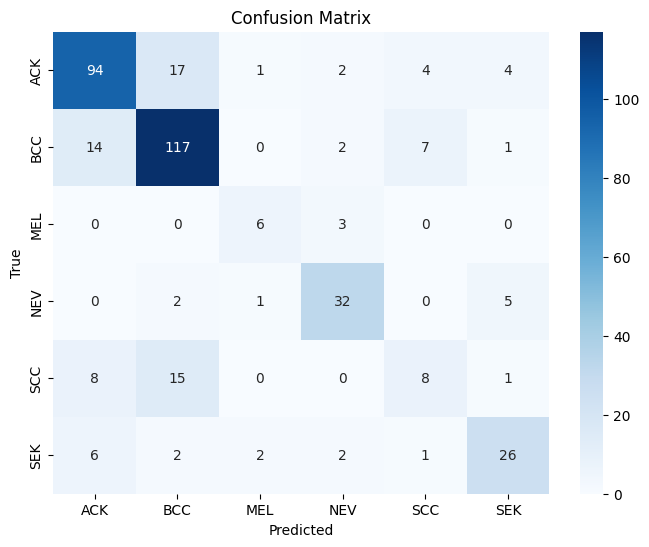

In [ ]:
class_names = label_encoder.classes_.tolist()
evaluate_classification(model, val_loader, device, class_names=label_encoder.classes_.tolist())